<a href="https://colab.research.google.com/github/lcipolina/escher/blob/master/Img_Class/ClipReranker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Colab version of this repo

https://github.com/mehdidc/clip_rerank

Thanks to @pbaylies and @afiaka87 and @alstroemeria313

In [ ]:
!git clone https://github.com/openai/CLIP && cd CLIP && pip install -e .

fatal: destination path 'CLIP' already exists and is not an empty directory.


In [ ]:
!pip install clize --quiet

In [ ]:
!pip install gdown

In [ ]:
import os
from clize import run
import torch
from CLIP import clip
from PIL import Image
from glob import glob

In [ ]:
import gdown

# a file
url = "https://drive.google.com/file/d/1BPsYLdfE9TPXTsx05pfS72w0uyzzKoHu/view?usp=sharing"
output = "a.zip"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1BPsYLdfE9TPXTsx05pfS72w0uyzzKoHu
To: /content/a.zip
100%|██████████| 35.3M/35.3M [00:00<00:00, 200MB/s]


'a.zip'

In [ ]:
import gdown

# a file
url = "https://drive.google.com/file/d/1cBFlNhbnkLQ0_sOM10OcV1Jtd5wwxUOr/view?usp=sharing"
output = "model.ckpt"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1cBFlNhbnkLQ0_sOM10OcV1Jtd5wwxUOr
To: /content/model.ckpt
100%|██████████| 9.80M/9.80M [00:00<00:00, 119MB/s]


'model.ckpt'

In [ ]:
!unzip a.zip -d a

Archive:  a.zip
   creating: a/0-bis/
  inflating: a/0-bis/.DS_Store       
  inflating: a/__MACOSX/0-bis/._.DS_Store  
   creating: a/0-bis/BAD/
   creating: a/0-bis/GOOD/
  inflating: a/0-bis/BAD/output_13.png  
  inflating: a/__MACOSX/0-bis/BAD/._output_13.png  
  inflating: a/0-bis/BAD/output_2 (3).png  
  inflating: a/__MACOSX/0-bis/BAD/._output_2 (3).png  
  inflating: a/0-bis/BAD/output_15 (1).png  
  inflating: a/__MACOSX/0-bis/BAD/._output_15 (1).png  
  inflating: a/0-bis/BAD/output_6 (1).png  
  inflating: a/__MACOSX/0-bis/BAD/._output_6 (1).png  
  inflating: a/0-bis/BAD/output_220220414-104425.png  
  inflating: a/__MACOSX/0-bis/BAD/._output_220220414-104425.png  
  inflating: a/0-bis/BAD/output_1 (5).png  
  inflating: a/__MACOSX/0-bis/BAD/._output_1 (5).png  
  inflating: a/0-bis/BAD/output_0 (4).png  
  inflating: a/__MACOSX/0-bis/BAD/._output_0 (4).png  
  inflating: a/0-bis/BAD/output_3 (2).png  
  inflating: a/__MACOSX/0-bis/BAD/._output_3 (2).png  
  inflating: a/0-

In [ ]:
from PIL import Image
from torchvision import models, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F


class Discriminator(nn.Module):
    def __init__(self, in_feature_size = 118, batch_size = 1):
        
        super(Discriminator, self).__init__()
        self.batch_size = batch_size
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.bn1 = nn.BatchNorm2d(64, affine=False)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.bn2 = nn.BatchNorm2d(128, affine=False)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.bn3 = nn.BatchNorm2d(256, affine=False)
        self.conv4 = nn.Conv2d(256, 512, 3)
        self.bn4 = nn.BatchNorm2d(512, affine=False)
        self.conv5 = nn.Conv2d(512, 1, 3)
        self.fc1 = nn.Linear(in_feature_size * in_feature_size , 64)
        self.fc2 = nn.Linear(64, 8)
        self.fc3 = nn.Linear(8, 2)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.conv5(x)
        x = x.view(1, -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

device = "cuda"
net = Discriminator()
net = nn.DataParallel(net, device_ids=[0])
net.load_state_dict(torch.load("model.ckpt"))
net.eval()

DataParallel(
  (module): Discriminator(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (conv5): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1))
    (fc1): Linear(in_features=13924, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=8, bias=True)
    (fc3): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [ ]:
transform = transforms.Compose([
            transforms.Resize([128, 128]), # Resizing the image as the VGG only take 224 x 244 as input size
            transforms.RandomHorizontalFlip(), # Flip the data horizontally
            #TODO if it is needed, add the random crop
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5), std=(0.5))
        ])


In [ ]:
def main(pattern, text="a gallery with arches wooden windows and arcades and floors with tiles escher", target_folder="reranked", top:int=None):
    device = "cuda"
    model, preprocess = clip.load("ViT-B/32", device=device)
    paths = glob(pattern, recursive = True)
    score = {}
    score_good = {}
    score_bad = {} 
    actual = []
    predicted = []
    for path in paths:
        image = preprocess(Image.open(path)).unsqueeze(0).to(device)
        image_disc =  torch.unsqueeze(transform(Image.open(path)), 0)
        text = "a gallery with arches wooden windows and arcades and floors with tiles escher"
        text = clip.tokenize([text]).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)
            logits_per_image, logits_pertext = model(image, text)
            logits_disc = torch.nn.functional.softmax(net(image_disc))
            index = torch.argmax(logits_disc).item()
            if "bad" in path.lower():
              actual.append(0)
            else:
              actual.append(1)

            predicted.append(index)
            if index == 0:
              score_bad[path] = logits_per_image.item()
            else:
              score_good[path] = logits_per_image.item()
            score[path] =  logits_per_image.item()
            print(path, score[path])
    paths = sorted(paths, key=lambda f:-score[f])
    if top:
        paths = paths[0:top]
    os.makedirs(target_folder, exist_ok=True)
    for i, path in enumerate(paths):
        out_path = os.path.join(target_folder, f"{i:010d}.png")
        Image.open(path).save(out_path)
    return score, score_bad, score_good, actual, predicted
#if name == "main":
#    run(main)

In [ ]:
score, score_bad, score_good, actual, predicted = main('./a/**/*.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


./a/0-bis/GOOD/output_5 (3).png 26.796875
./a/0-bis/GOOD/output_1 (4).png 27.40625
./a/0-bis/GOOD/output_13 (4).png 24.8125
./a/0-bis/GOOD/output_10 (2).png 25.828125
./a/0-bis/GOOD/output_19 (5).png 26.4375
./a/0-bis/GOOD/output_11 (3).png 26.921875
./a/0-bis/GOOD/output_9 (1).png 25.765625
./a/0-bis/GOOD/output_21-20220414-105111.png 28.03125
./a/0-bis/GOOD/output_23 (2).png 25.921875
./a/0-bis/GOOD/output_13 (1).png 26.0625
./a/0-bis/GOOD/output_18 (1).png 26.203125
./a/0-bis/GOOD/output_16.png 28.359375
./a/0-bis/GOOD/output_2 (1).png 26.65625
./a/0-bis/GOOD/output_21-20220414-110033.png 27.71875
./a/0-bis/GOOD/output_16 copy.png 25.625
./a/0-bis/GOOD/output_11-20220414-105111.png 27.59375
./a/0-bis/GOOD/output_7.png 25.671875
./a/0-bis/GOOD/output_8.png 27.65625
./a/0-bis/GOOD/output_10 (4).png 26.96875
./a/0-bis/GOOD/output_23 (1).png 26.53125
./a/0-bis/GOOD/output_24.png 27.90625
./a/0-bis/GOOD/output_0 (2).png 26.09375
./a/0-bis/GOOD/output_4 (2).png 27.078125
./a/0-bis/GOOD/ou

In [ ]:
import numpy as np
from scipy import stats

def find_stats(score, title):
  scores_raw = np.array(list(score.values()))
  print(title)
  print(f'Mean: {np.mean(scores_raw)}')
  print(f'Median: {np.median(scores_raw)}')
  print(f'Variance: {np.std(scores_raw)}')


find_stats(score, "Total Stats")
find_stats(score_good, "Stats Good Images")
find_stats(score_bad, "Stats bad images")

Total Stats
Mean: 26.588057170542637
Median: 26.5859375
Variance: 0.8382623682881859
Stats Good Images
Mean: 26.540251358695652
Median: 26.5
Variance: 0.824442031031971
Stats bad images
Mean: 26.614551957831324
Median: 26.609375
Variance: 0.8446600760327238


In [ ]:
!pip3 install seaborn


In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(actual, predicted, normalize = "true")
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


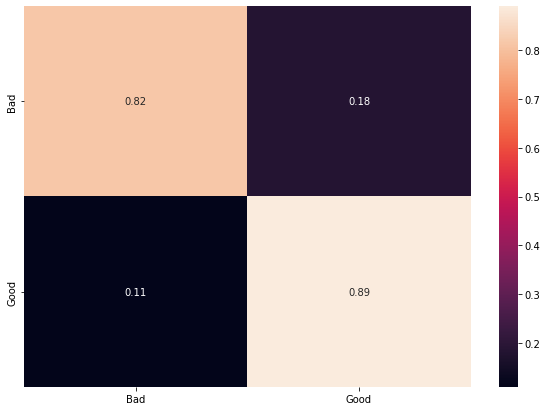

In [ ]:
df_cm = pd.DataFrame(cf_matrix, index = [i for i in ["Bad", "Good"]],
                  columns = [i for i in  ["Bad", "Good"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)